In [1]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms

In [33]:
pre_process = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor(),
#  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

def show(img: torch.Tensor
         ) -> None:
    img = img.clone()
    min, max = img.min(), img.max()
    img.clamp_(min=min, max=max)
    img.add_(-min).div_(max-min+1e-5)
    
    plt.imshow(img.permute(1, 2, 0).numpy(), interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    
img_path = "/home/chenty/workspace/data/food101/food-101/images/apple_pie/229142.jpg"
image = Image.open(img_path).convert("RGB")
image_tensor = pre_process(image)
trigger_path = "./watermark1.png"
trigger_image = Image.open(trigger_path).convert("RGB")
trigger_tensor = pre_process(trigger_image)

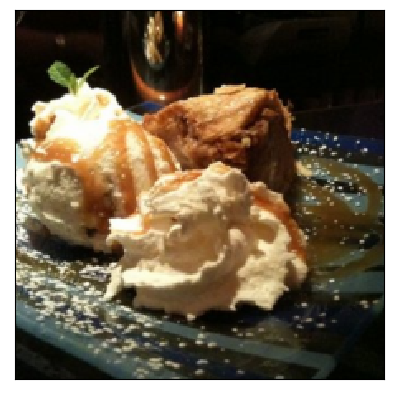

In [9]:
show(image_tensor)

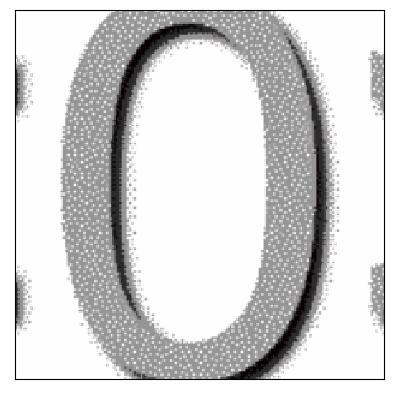

In [35]:
show(trigger_tensor)

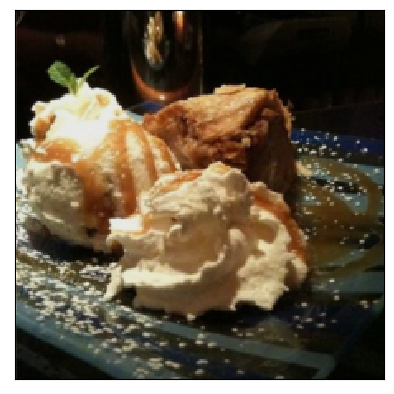

In [54]:
import numpy as np
def roll_n(X, axis, n):
    f_idx = tuple(slice(None, None, None) 
            if i != axis else slice(0, n, None) 
            for i in range(X.dim()))
    b_idx = tuple(slice(None, None, None) 
            if i != axis else slice(n, None, None) 
            for i in range(X.dim()))
    front = X[f_idx]
    back = X[b_idx]
    return torch.cat([back, front], axis)

def fftshift(X):
    real, imag = X.chunk(chunks=2, dim=-1)
    real, imag = real.squeeze(dim=-1), imag.squeeze(dim=-1)
    for dim in range(2, len(real.size())):
        real = roll_n(real, axis=dim, 
                      n=int(np.ceil(real.size(dim) / 2)))
        imag = roll_n(imag, axis=dim, 
                      n=int(np.ceil(imag.size(dim) / 2)))
    real, imag = real.unsqueeze(dim=-1), imag.unsqueeze(dim=-1)
    X = torch.cat((real,imag),dim=1)
    return torch.squeeze(X)

def ifftshift(X):
    real, imag = X.chunk(chunks=2, dim=-1)
    real, imag = real.squeeze(dim=-1), imag.squeeze(dim=-1)
    
    for dim in range(len(real.size()) - 1, 1, -1):
        real = roll_n(real, axis=dim,  n=int(np.floor(real.size(dim) / 2)))
        imag = roll_n(imag, axis=dim, n=int(np.floor(imag.size(dim) / 2)))
    real, imag = real.unsqueeze(dim=-1), imag.unsqueeze(dim=-1)
    X = torch.cat((real, imag), dim=1)
    return torch.squeeze(X)



r_channel = image_tensor[0, :, :]
g_channel = image_tensor[1, :, :]
b_channel = image_tensor[2, :, :]

trigger_r, trigger_g, trigger_b = trigger_tensor[0, :, :],  trigger_tensor[1, :, :],  trigger_tensor[2, :, :]

alpha = 0.1
new_r = ifftshift(torch.fft.fft(r_channel)) + alpha * trigger_r
new_g = ifftshift(torch.fft.fft(g_channel)) + alpha * trigger_g
new_b = ifftshift(torch.fft.fft(b_channel)) + alpha * trigger_b

new_r = torch.fft.ifft(new_r)
new_g = torch.fft.ifft(new_g)
new_b = torch.fft.ifft(new_b)

new_image = torch.cat([x.unsqueeze(0) for x in [new_r, new_g, new_b]], dim=0).type(torch.float32)

# r_channel_f = torch.fft.fft(r_channel)
# ifft_shift_img = ifftshift(r_channel_f)
# r_channel_i = torch.fft.ifft(ifft_shift_img).type(torch.float32)
# print(r_channel_f)
# print(r_channel_i.shape)
# print(r_channel_i)
# print(image_tensor[1, :, :].shape)
# new_image = torch.cat([r_channel_i.unsqueeze(0), image_tensor[1, :, :].unsqueeze(0), image_tensor[2, :, :].unsqueeze(0)], dim=0)
# f_image_shifted = fft_shift(f_image)
# mag = 20 * f_image_shifted.norm(dim=-1).log()
show(new_image)
delta = new_image - image_tensor
# show(delta)
# print(delta)